## 超參數配置

In [1]:
# 前處理參數
seq_len = 5  # 序列長度(查看過去之天數)
train_size = 0.7  # 分割資料比例

# 模型參數
input_size = 1  # 餵入的特徵種數
hidden_size = 5  # model隱藏層
num_layers = 1  # model層數
epoch = 3000  # 訓練回合數
lr = 0.001  # 學習率


In [2]:
#載入相關套件
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# 使用GPU訓練
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# 強迫固定亂數，方便研究用
np.random.seed(1)
torch.manual_seed(1)

## 資料前處理

### 讀取原始資料

In [5]:
Location = r'./data/sum_check_out.xlsx'  # 設定資料路徑
df = pd.read_excel(Location)
#df = df.T  # 資料旋轉
df

,Year,week,異動數量
0,2020.0,12,0
1,NaN,13,1170
2,NaN,14,0
3,NaN,15,1205
4,NaN,16,955
...,...,...,...
97,NaN,4,1000
98,NaN,5,0
99,NaN,6,1441
100,NaN,7,1146


### 修正資料格式

In [6]:
#  填補年份NaN值
df['Year'] = df['Year'].fillna(method='ffill',axis=0)
df

,Year,week,異動數量
0,2020.0,12,0
1,2020.0,13,1170
2,2020.0,14,0
3,2020.0,15,1205
4,2020.0,16,955
...,...,...,...
97,2022.0,4,1000
98,2022.0,5,0
99,2022.0,6,1441
100,2022.0,7,1146


In [7]:
#column_name = {0:"Date", 1:"Quantity"}
# 重新命名-欄名稱
#df.rename(columns=column_name, inplace=True)  # columns=修改欄；index=修改列；inplace=True 覆蓋原本數據
#df

In [8]:
print("[before type]\n", df.dtypes)
df = df.astype('int64')  # 全部轉int64
#df["異動數量"] = pd.to_numeric(df['異動數量'])  # 若為字串(Object)，轉為整數(int64)
print("\n[after type]:\n", df.dtypes)

[before type]
 Year    float64
week      int64
異動數量      int64
dtype: object

[after type]:
 Year    int64
week    int64
異動數量    int64
dtype: object


In [9]:
df = df.set_index(['Year','week'])  # 將某欄位換成索引名稱(Date欄位->index)，原本Date欄位消失
df

異動數量
Year week      
2020 12       0
     13    1170
     14       0
     15    1205
     16     955
...         ...
2022 4     1000
     5        0
     6     1441
     7     1146
     8      985

[102 rows x 1 columns]

In [10]:
# 去除null空值
null_num = df.isnull().sum().sum()  # 求null個數
print("[before]\nnull_number=", null_num)
df = df.dropna()  # 去除null

null_num = df.isnull().sum().sum()  # 求null個數
print("\n[after]\nnull_number=", null_num)

print("\nData Total Series:",len(df))

[before]
null_number= 0

[after]
null_number= 0

Data Total Series: 102


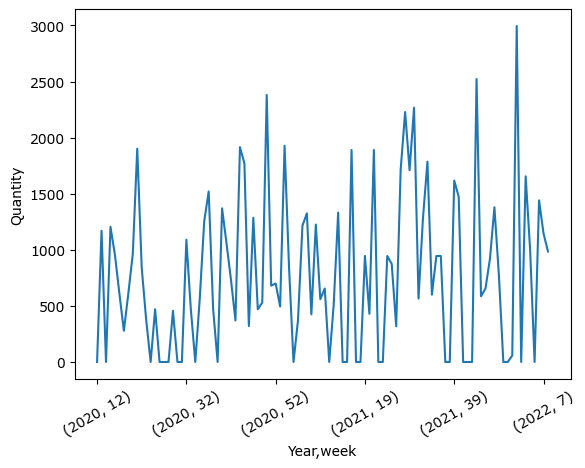

In [11]:
df.plot(legend=None)  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

In [12]:
# []:只能單列； [[]]:可以多列
df = df[["異動數量"]].astype('float32')  # 轉成float [model餵入data需要的格式]
df

異動數量
Year week        
2020 12       0.0
     13    1170.0
     14       0.0
     15    1205.0
     16     955.0
...           ...
2022 4     1000.0
     5        0.0
     6     1441.0
     7     1146.0
     8      985.0

[102 rows x 1 columns]

In [13]:
dataset = df[["異動數量"]].values  # 轉成一維，形成dataset
print("dataset:", dataset.shape)
print(dataset[0:5])

dataset: (102, 1)
[[   0.]
 [1170.]
 [   0.]
 [1205.]
 [ 955.]]


### 資料正規化

In [14]:
scaler = MinMaxScaler()  # 選擇計算類型
ori_dataset = dataset
dataset = scaler.fit_transform(dataset)  # Normalization 歸一化0~1數值

print("正規化:")
for i in range(20):  # 察看結果用
    print(ori_dataset[i]," -> ",dataset[i])

正規化:
[0.]  ->  [0.]
[1170.]  ->  [0.3906511]
[0.]  ->  [0.]
[1205.]  ->  [0.40233722]
[955.]  ->  [0.3188648]
[610.]  ->  [0.2036728]
[278.]  ->  [0.09282137]
[610.]  ->  [0.2036728]
[963.]  ->  [0.32153592]
[1901.]  ->  [0.63472456]
[840.]  ->  [0.28046745]
[375.]  ->  [0.12520869]
[0.]  ->  [0.]
[470.]  ->  [0.15692821]
[0.]  ->  [0.]
[0.]  ->  [0.]
[0.]  ->  [0.]
[456.]  ->  [0.15225376]
[0.]  ->  [0.]
[0.]  ->  [0.]


### 切割Train, Test資料

In [15]:
#將資料集分成 訓練集、測試集
def split_data(data, train_size):
    train_size = int(dataset.shape[0] * train_size)
    test_size = dataset.shape[0] - train_size
    print("全部:", len(dataset), "筆 \n\n訓練資料:", train_size,"筆 \n測試資料:", test_size,"筆")
    train_data = dataset[:train_size]
    
    test_data = dataset[(train_size-seq_len):]  # 第一筆test_data即為Y，故要包含前面seq_len筆資料
    print("\nTrain_data",train_data.shape)
    print("Test_data",test_data.shape)
    print("\n內容值預覽:\n", train_data[20:25])
    return train_data, test_data

train_data, test_data = split_data(dataset, train_size)

全部: 102 筆 

訓練資料: 71 筆 
測試資料: 31 筆

Train_data (71, 1)
Test_data (36, 1)

內容值預覽:
 [[0.3639399 ]
 [0.15692821]
 [0.        ]
 [0.18864775]
 [0.41903174]]


### 調整餵入模型之序列資料

In [16]:
# 生成過去seq_len天(X)+當天(Y)； Y=ground true
def create_seq(data, seq_len):
    print("[before]\n", data.shape)
    x = []
    y = []
    for i in range(len(data)-seq_len):  # 不需多減1
        #print("有",i+1,"組")
        _x = data[i:(i+seq_len)]  # 0,1,2...(seq_len-1)
        _y = data[(i+seq_len)]  # seq_len
        x.append(_x)
        y.append(_y)
    x = torch.as_tensor(np.array(x))  # 轉成 numpy(速度較快) -> tensor
    y = torch.as_tensor(np.array(y))
    print("[after input]\n", x.shape,"\n")
    return x, y

train_x, train_y = create_seq(train_data, seq_len)
test_x, test_y = create_seq(test_data, seq_len)

[before]
 (71, 1)
[after input]
 torch.Size([66, 5, 1]) 

[before]
 (36, 1)
[after input]
 torch.Size([31, 5, 1]) 



- 我的筆記: 
    - 假設model的batch_first=False
    - batch_size, seq_len, hidden_size
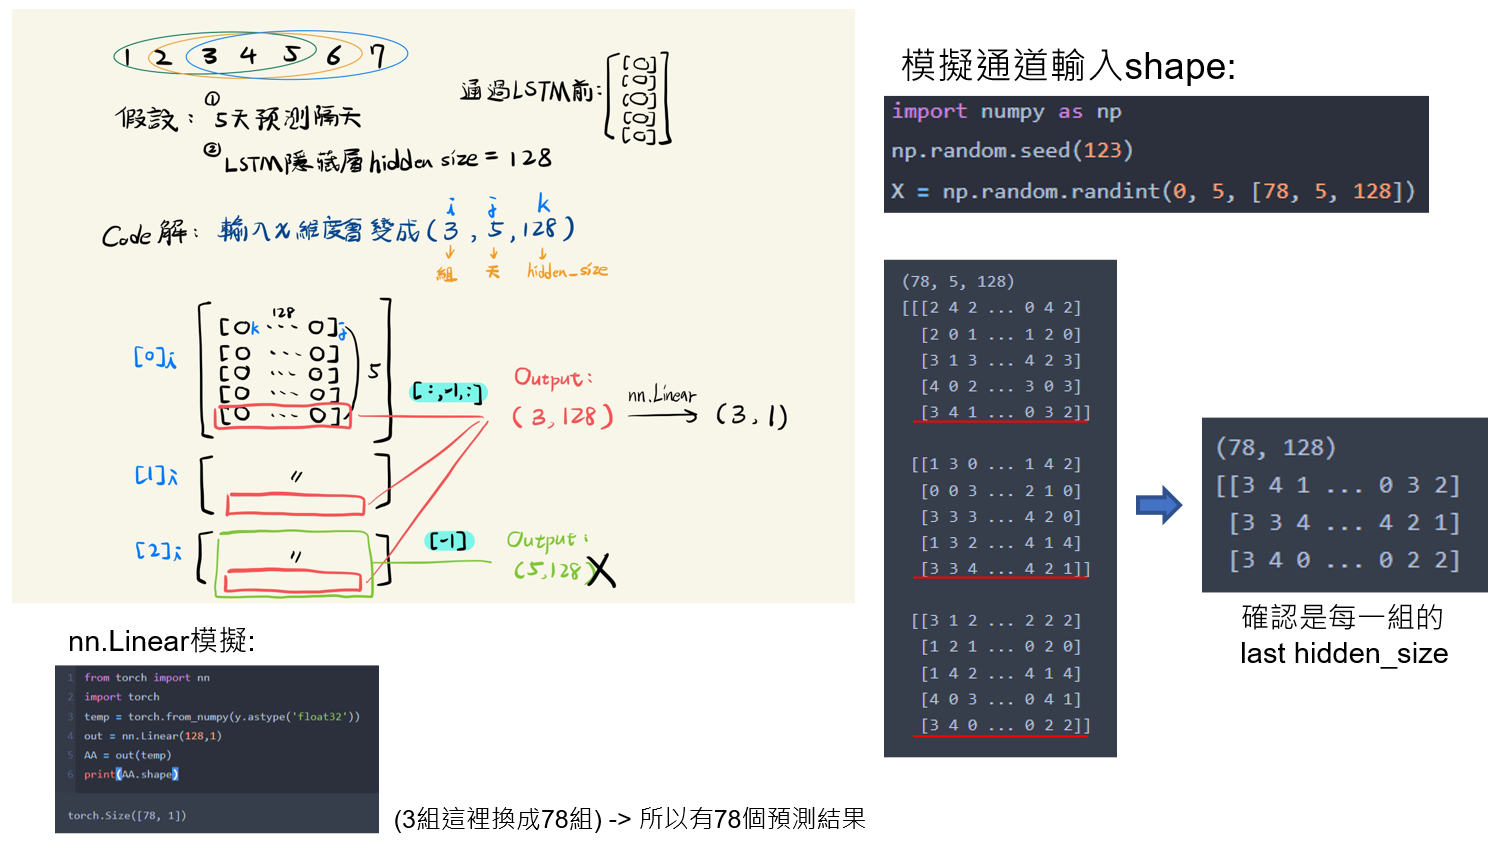

## 建立模型

### 參數解釋

- Pytorch裡的LSTM單元接受的輸入都必須是3維的張量(Tensors).每一維代表的意思不能弄錯。
- 第一維(i)體現的是序列（sequence）結構,也就是序列的個數，用文章來說，就是每個句子的長度，因為是餵給網絡模型，一般都設定為確定的長度，也就是我們餵給LSTM神經元的每個句子的長度，當然，如果是其他的帶有帶有序列形式的數據，則表示一個明確分割單位長度。
- 第二維(j)度體現的是batch_size，也就是一次性餵給網絡多少條句子，或者股票數據中的，一次性餵給模型多少是個時間單位的數據，具體到每個時刻，也就是一次性餵給特定時刻處理的單元的單詞數或者該時刻應該餵給的股票數據的條數。
- 第三維(k)體現的是輸入的元素（elements of input），也就是，每個具體的單詞用多少維向量來表示，或者股票數據中每一個具體的時刻的採集多少具體的值，比如最低價、最高價、均價、5日均價、10均價，則k=5，等等
----
- H0-Hn是什麼意思呢？就是每個時刻中間神經元應該保存的這一時刻的根據輸入和上一課的時候的中間狀態值應該產生的本時刻的狀態值，這個數據單元是起的作用就是記錄這一時刻之前考慮到所有之前輸入的狀態值，形狀應該是和特定時刻的輸出一致。

- c0-cn就是開關，決定每個神經元的隱藏狀態值是否會影響的下一時刻的神經元的處理，形狀應該和h0-hn一致。

- 當然如果是雙向，和多隱藏層還應該考慮方向和隱藏層的層數。
----
- lstm的輸出會有 output和最後一個CELL的 hidden state, cell state，在pytorch裏頭，output的值其實就是每個cell的hidden state集合起來的陣列
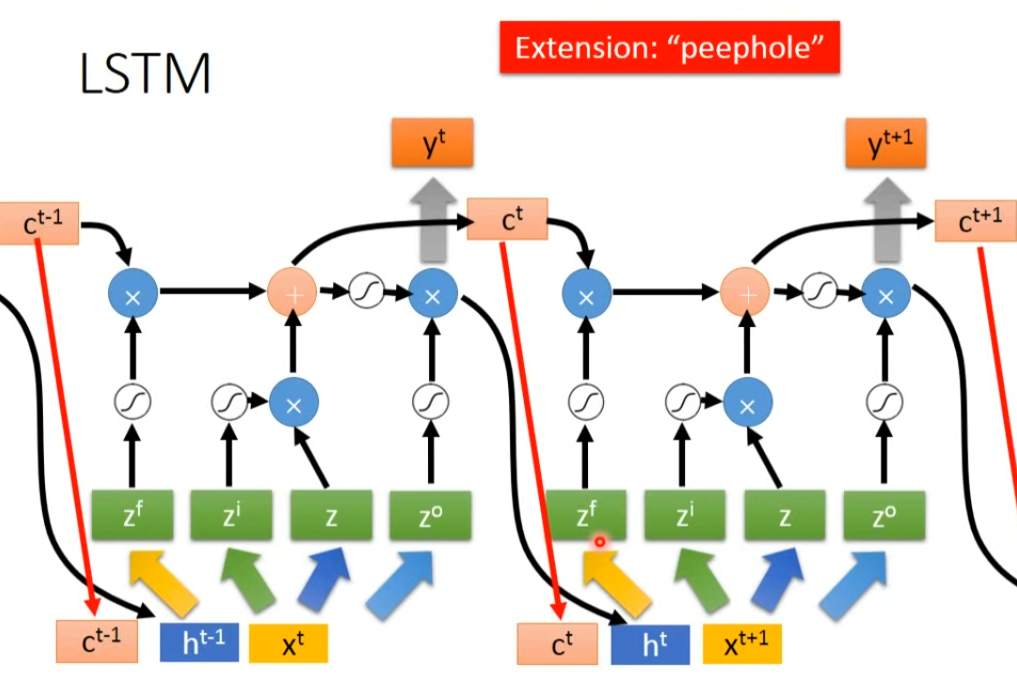
- 參考資料1: [Pytorch的LSTM的理解](https://zhuanlan.zhihu.com/p/41261640)
- 參考資料2: [Pytorch實作LSTM執行訊號預測](https://zhenglungwu.medium.com/pytorch%E5%AF%A6%E4%BD%9Clstm%E5%9F%B7%E8%A1%8C%E8%A8%8A%E8%99%9F%E9%A0%90%E6%B8%AC-d1d3f17549e7)

### Model

In [17]:
# LSTM Model
class LSTM(nn.Module): # Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, seq_len, hidden_size, num_layers):
        super().__init__()
        # 外部()參數導入
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        # Q seq_len網路上有否使用到
        
        self.rnn = nn.LSTM(
            input_size = input_size,  # 餵入的特徵種數 (ex:預測訂單量, input_szie=1)
            hidden_size = hidden_size,  # hidden state(h)的feature numbers
            num_layers = num_layers,
            batch_first = True  # Default:(seq_len, batch_size, hidden_size)； True:(batch_size, seq_len, hidden_size)
        )
        self.fc = nn.Linear(self.hidden_size, 1)  # 串接:(hidden_size) -> (1)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # h,c:(num_layers * num_directions, batch_size, hidden_size)     
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)    
        model_out, (h_n, c_n) = self.rnn(x, (h_0, c_0))
        
        # model_out:(batch_size, seq_len, hidden_size)
        fc_in = model_out[:,-1,:]  # 抓取每組的最後一個seq_len
        # fc_in:(batch_size, hidden_size)
        fc_out = self.fc(fc_in)  # 全連接層
        # fc_out:(batch_size, 1)
        return fc_out    
# 呼叫方法
model = LSTM(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU

### 查看模型Shape

In [18]:
def look_model_shape(seq_len, hidden_size, num_layers, device):
    model = LSTM(seq_len, hidden_size, num_layers).to(device)
    print("查看模型結構:\n",model)
    print("\n查看網路參數:")
    for name, parameters in model.named_parameters():
        print(name, ':', parameters.size())
        
look_model_shape(seq_len, hidden_size, num_layers, device)

查看模型結構:
 LSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

查看網路參數:
rnn.weight_ih_l0 : torch.Size([20, 1])
rnn.weight_hh_l0 : torch.Size([20, 5])
rnn.bias_ih_l0 : torch.Size([20])
rnn.bias_hh_l0 : torch.Size([20])
fc.weight : torch.Size([1, 5])
fc.bias : torch.Size([1])


## 訓練模型

In [19]:
def train(train_x, train_y, epoch, lr):
    loss_fn = torch.nn.MSELoss(reduction='mean')  # 設定loss, default='mean'
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=0.000001)  # 設定optimization
    model.train()  # 開啟訓練模式
    for epoch in range(epoch):
        # 資料移動到GPU計算
        train_x, train_y = train_x.to(device), train_y.to(device)
        # 優化器清空(Reset Gradient)
        optimizer.zero_grad()  
        # 餵入模型
        output = model(train_x)
        if epoch <=0: print("模型output shape:", output.shape)
            
        # 計算loss值
        loss = loss_fn(output, train_y)
        loss.backward()  # 反向傳播->計算當前Gradient
        optimizer.step()  # 更新Gradient，根據Gradient Descent更新網路參數
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, loss: {loss.item():.5f}')
            torch.save(model,'best_model.pth')
# 呼叫方法
train(train_x, train_y, epoch, lr)

模型output shape: torch.Size([66, 1])
Epoch: 0, loss: 0.04814
Epoch: 100, loss: 0.04755
Epoch: 200, loss: 0.04734
Epoch: 300, loss: 0.04680
Epoch: 400, loss: 0.04486
Epoch: 500, loss: 0.04238
Epoch: 600, loss: 0.04119
Epoch: 700, loss: 0.03960
Epoch: 800, loss: 0.03847
Epoch: 900, loss: 0.03596
Epoch: 1000, loss: 0.03293
Epoch: 1100, loss: 0.02975
Epoch: 1200, loss: 0.02774
Epoch: 1300, loss: 0.02640
Epoch: 1400, loss: 0.02508
Epoch: 1500, loss: 0.02366
Epoch: 1600, loss: 0.02252
Epoch: 1700, loss: 0.02171
Epoch: 1800, loss: 0.02087
Epoch: 1900, loss: 0.01989
Epoch: 2000, loss: 0.01861
Epoch: 2100, loss: 0.01702
Epoch: 2200, loss: 0.01560
Epoch: 2300, loss: 0.01461
Epoch: 2400, loss: 0.01396
Epoch: 2500, loss: 0.01354
Epoch: 2600, loss: 0.01319
Epoch: 2700, loss: 0.01291
Epoch: 2800, loss: 0.01264
Epoch: 2900, loss: 0.01239


## 評估模型

In [20]:
model.eval()
# 取得model預測值
train_pred = model(train_x.to(device)).cpu().detach().numpy()
test_pred = model(test_x.to(device)).cpu().detach().numpy()

print("model output shape:", train_pred.shape)

model output shape: (66, 1)


In [21]:
# 還原常態化 "預測值"
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# 還原常態化 "Ground True值"
dataset = scaler.inverse_transform(dataset)  # 原始資料
train_gt = scaler.inverse_transform(train_y)  # train ground true
test_gt = scaler.inverse_transform(test_y)  # test ground true

# 還原後，四捨五入、float -> int
dataset = np.add(dataset, 0.5).astype('int')
train_pred = np.add(train_pred, 0.5).astype('int')
test_pred = np.add(test_pred, 0.5).astype('int')
train_gt = np.add(train_gt, 0.5).astype('int')
test_gt = np.add(test_gt, 0.5).astype('int')

"""
# 轉成一維 (98,1)->(1,98)  或  (98,)->(98,1)
train_pred = train_pred.reshape(1,-1)
test_pred = test_pred.reshape(1,-1)
train_gt = train_gt.reshape(1,-1)
test_gt = test_gt.reshape(1,-1)
"""

'\n# 轉成一維 (98,1)->(1,98)  或  (98,)->(98,1)\ntrain_pred = train_pred.reshape(1,-1)\ntest_pred = test_pred.reshape(1,-1)\ntrain_gt = train_gt.reshape(1,-1)\ntest_gt = test_gt.reshape(1,-1)\n'

In [22]:
# 轉換shape
train_pred_to_excel = train_pred.reshape(1,-1)
train_gt_to_excel = train_gt.reshape(1,-1)

test_pred_to_excel = test_pred.reshape(1,-1)
test_gt_to_excel = test_gt.reshape(1,-1)

In [23]:
# 匯出test資料集的正確值和預測值
a = pd.DataFrame(test_gt_to_excel)
b = pd.DataFrame(test_pred_to_excel)

Test_Result_to_excel = pd.DataFrame()
Test_Result_to_excel = Test_Result_to_excel.append(a, ignore_index=True)
Test_Result_to_excel = Test_Result_to_excel.append(b, ignore_index=True)
to_excel_name = {0:"Test_gt", 1:"Test_pred"}
Test_Result_to_excel.rename(index = to_excel_name, inplace=True)

Test_Result_to_excel.to_excel('./data/Test_Output.xlsx', sheet_name='A', index=True)
Test_Result_to_excel

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Test_gt,2267,565,1283,1786,600,945,945,0,0,1617,...,0,58,2995,0,1655,1000,0,1441,1146,985
Test_pred,492,158,472,828,986,588,191,739,635,2179,...,1229,913,1370,1262,1784,1617,1598,537,1921,827


In [24]:
from sklearn.metrics import mean_squared_error
import math
train_Score = mean_squared_error(train_gt, train_pred)
#train_Score = math.sqrt(mean_squared_error(train_gt, train_pred))
#test_Score = math.sqrt(mean_squared_error(test_gt, test_pred))
train_Score

109183.45454545454

## 可視化結果

### 可視化前處理

In [25]:
# 查看畫圖時shape是否一致
print("原始資料(前/後) -> ", df.index.values.shape, " ", dataset.shape)
print("Train資料(前/後) -> ",train_pred.shape, " ", df.index.values[seq_len : train_pred.shape[0]+seq_len].shape)
print("Test資料(前/後) ->  ",test_pred.shape, " ", df.index.values[test_pred.shape[0]+seq_len : ].shape)

原始資料(前/後) ->  (102,)   (102, 1)
Train資料(前/後) ->  (66, 1)   (66,)
Test資料(前/後) ->   (31, 1)   (66,)


In [26]:
date = []
for i in range(len(df)):
    date.append(df.index[i][1])
date = np.array(date)
date = date.reshape(-1,1)
date

array([[12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],

In [27]:
df = df.reset_index()
df

,Year,week,異動數量
0,2020,12,0.0
1,2020,13,1170.0
2,2020,14,0.0
3,2020,15,1205.0
4,2020,16,955.0
...,...,...,...
97,2022,4,1000.0
98,2022,5,0.0
99,2022,6,1441.0
100,2022,7,1146.0


In [28]:
# index = Year_week (合併年/週)
index_num = df['Year'].astype('str') + '_' + df['week'].astype('str') 
index_num

0      2020_12
1      2020_13
2      2020_14
3      2020_15
4      2020_16
        ...   
97      2022_4
98      2022_5
99      2022_6
100     2022_7
101     2022_8
Length: 102, dtype: object

### 整體結果

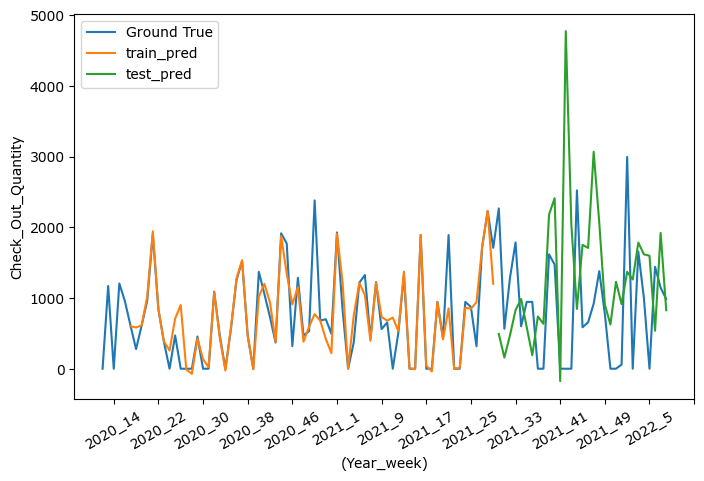

In [29]:
# 劃出結果
import matplotlib.dates as mdates
plt.figure(figsize = (8,5))
# 參考: https://sharkyun.medium.com/python%E8%A6%96%E8%A6%BA%E5%9C%96-x%E8%BB%B8-%E6%97%A5%E6%9C%9F%E8%99%95%E7%90%86-c8f421b52beb
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))  # 設定x軸刻度間距 

#date = df.index.values  # date = 取出的日期陣列
plt.plot( index_num , dataset, label='Ground True')  # 原始資料Ground True
plt.plot( (index_num[seq_len : train_pred.shape[0]+seq_len]) , train_pred, label='train_pred')  # train_pred
plt.plot( (index_num[train_pred.shape[0]+seq_len : ]) , test_pred, label='test_pred')  # test_pred

plt.xlabel("(Year_week)")
plt.ylabel("Check_Out_Quantity")
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [30]:
index_num[:]  # 查看對應區間 [tart_day:nd_day]

0      2020_12
1      2020_13
2      2020_14
3      2020_15
4      2020_16
        ...   
97      2022_4
98      2022_5
99      2022_6
100     2022_7
101     2022_8
Length: 102, dtype: object

### 指定某區間結果

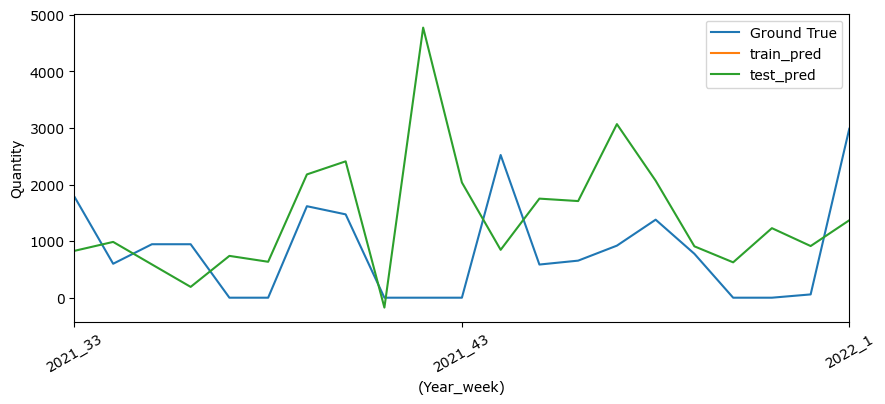

In [31]:
# 選擇想查看的區間(根據上面號碼)
start_day = 74
end_day = 94

plt.figure(figsize = (10,4))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
date = df.index.values  # date = 取出的日期陣列
gt_plot = plt.plot( index_num , dataset, label='Ground True')
train_pred_plot = plt.plot( (index_num[seq_len : train_pred.shape[0]+seq_len]) , train_pred, label='train_pred')
test_pred_plot = plt.plot( (index_num[train_pred.shape[0]+seq_len : ]) , test_pred, label='test_pred')

# 調整顯示範圍
plt.xlim(xmin=start_day, xmax=end_day)  

plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()
plt.show()

## 驗證成效

In [32]:
#載入相關套件
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 參數
seq_len = seq_len  # 序列長度(查看過去之天數)

In [33]:
# LSTM Model
class LSTM(nn.Module): # Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, seq_len, hidden_size, num_layers):
        super().__init__()
        # 外部()參數導入
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        # Q seq_len網路上有否使用到
        
        self.rnn = nn.LSTM(
            input_size = input_size,  # 餵入的特徵種數 (ex:預測訂單量, input_szie=1)
            hidden_size = hidden_size,  # hidden state(h)的feature numbers
            num_layers = num_layers,
            batch_first = True  # Default:(seq_len, batch_size, hidden_size)； True:(batch_size, seq_len, hidden_size)
        )
        self.fc = nn.Linear(self.hidden_size, 1)  # 串接:(hidden_size) -> (1)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # h,c:(num_layers * num_directions, batch_size, hidden_size)     
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)    
        model_out, (h_n, c_n) = self.rnn(x, (h_0, c_0))
        
        # model_out:(batch_size, seq_len, hidden_size)
        fc_in = model_out[:,-1,:]  # 抓取每組的最後一個seq_len
        # fc_in:(batch_size, hidden_size)
        fc_out = self.fc(fc_in)  # 全連接層
        # fc_out:(batch_size, 1)
        return fc_out    

In [34]:
# 讀取模型和處理好之data(為方便獨立驗證，已拉出一份excel檔)

# 要預測的變數
df_check_out = pd.read_excel('./data/sum_check_out.xlsx')  
df_put_in = pd.read_excel('./data/sum_put_in.xlsx')

# 選擇模型
best_model = torch.load('best_model.pth')  
best_model.eval()

# 使用GPU訓練
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# 模型使用GPU
best_model.to(device)

LSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

### Excel資料-統一日期範圍

In [35]:
df_check_out['Year'] = df_check_out['Year'].fillna(method='ffill',axis=0)  # 填滿缺值
df_check_out.head(10)

,Year,week,異動數量
0,2020.0,12,0
1,2020.0,13,1170
2,2020.0,14,0
3,2020.0,15,1205
4,2020.0,16,955
5,2020.0,17,610
6,2020.0,18,278
7,2020.0,19,610
8,2020.0,20,963
9,2020.0,21,1901


In [36]:
df_put_in['Year'] = df_put_in['Year'].fillna(method='ffill', axis=0)  # 填滿缺值
df_put_in.head(10)

,Year,week,異動數量
0,2020.0,12,647
1,2020.0,13,523
2,2020.0,14,393
3,2020.0,15,812
4,2020.0,16,1000
5,2020.0,17,565
6,2020.0,18,1020
7,2020.0,19,1415
8,2020.0,20,630
9,2020.0,21,1370


In [37]:
# 合併DataFrame (取聯集=outer, 交集=inner)
df_merge = pd.merge(df_put_in, df_check_out, on=['Year','week'], how='outer', suffixes=('_put_in', '_check_out'))
df_merge = df_merge.fillna(0)
df_merge.head(10)

,Year,week,異動數量_put_in,異動數量_check_out
0,2020.0,12,647,0
1,2020.0,13,523,1170
2,2020.0,14,393,0
3,2020.0,15,812,1205
4,2020.0,16,1000,955
5,2020.0,17,565,610
6,2020.0,18,1020,278
7,2020.0,19,1415,610
8,2020.0,20,630,963
9,2020.0,21,1370,1901


In [38]:
# 求出"真實入庫量"
put_in_gt = df_merge['異動數量_put_in']
put_in_gt = np.array(put_in_gt).reshape(-1, 1)
put_in_gt = put_in_gt[seq_len:]  # 從第seq_len筆資料開始(預測的第一天開始)
put_in_gt[0:5]

array([[ 565],
       [1020],
       [1415],
       [ 630],
       [1370]], dtype=int64)

In [39]:
# 求出"真實出庫量"
check_out_gt = df_merge['異動數量_check_out']
check_out_gt = np.array(check_out_gt).reshape(-1, 1)
check_out_gt[0:5]

array([[   0],
       [1170],
       [   0],
       [1205],
       [ 955]], dtype=int64)

In [40]:
# 求出"相差量" (入庫-出庫)
inventory_gt = df_merge['異動數量_put_in'].sub(df_merge['異動數量_check_out'], fill_value=0)  # fill_value: 自動補齊缺失計算
inventory_gt = np.array(inventory_gt).reshape(-1, 1)
#inventory_gt = inventory_gt[seq_len-1:]
inventory_gt[0:10]

array([[ 647],
       [-647],
       [ 393],
       [-393],
       [  45],
       [ -45],
       [ 742],
       [ 805],
       [-333],
       [-531]], dtype=int64)

In [41]:
# 求出"庫存量" (每週累積)
inventory_gt = np.cumsum(inventory_gt).reshape(-1, 1)
inventory_gt[0:10]

array([[ 647],
       [   0],
       [ 393],
       [   0],
       [  45],
       [   0],
       [ 742],
       [1547],
       [1214],
       [ 683]], dtype=int64)

### 時序資料-前處理

In [42]:
# 求出測資料之"日期"
get_date = pd.DataFrame()
get_date['Year'] = df_merge['Year']
get_date['week'] = df_merge['week']
get_date = get_date.astype('int64')
get_date = get_date
get_date

,Year,week
0,2020,12
1,2020,13
2,2020,14
3,2020,15
4,2020,16
...,...,...
97,2022,4
98,2022,5
99,2022,6
100,2022,7


In [43]:
# 正規化
scaler = MinMaxScaler()  # 選擇計算類型
df_check_out = check_out_gt
df_check_out = scaler.fit_transform(df_check_out)  # Normalization 歸一化0~1數值

print("正規化:")
for i in range(10):  # 察看結果用
    print(check_out_gt[i]," -> ",df_check_out[i])

正規化:
[0]  ->  [0.]
[1170]  ->  [0.39065109]
[0]  ->  [0.]
[1205]  ->  [0.40233723]
[955]  ->  [0.31886477]
[610]  ->  [0.20367279]
[278]  ->  [0.09282137]
[610]  ->  [0.20367279]
[963]  ->  [0.32153589]
[1901]  ->  [0.63472454]


In [44]:
# 生成過去seq_len天(X)+當天(Y)； Y=ground true
def create_seq(data, seq_len):
    print("時序資料轉換:\n")
    print("[before]\n", data.shape)
    x = []
    y = []
    for i in range(len(data)-seq_len):  # 不需多減1
        #print("有",i+1,"組")
        _x = data[i:(i+seq_len)]  # 0,1,2...(seq_len-1)
        _y = data[(i+seq_len)]  # seq_len
        x.append(_x)
        y.append(_y)
    x = torch.as_tensor(np.array(x))  # 轉成 numpy(速度較快) -> tensor
    y = torch.as_tensor(np.array(y))
    print("\n[after input]\n", x.shape,"\n")
    return x, y

test_x, test_y = create_seq(df_check_out, seq_len)
test_x = test_x.float()
test_y = test_y.float()

時序資料轉換:

[before]
 (102, 1)

[after input]
 torch.Size([97, 5, 1]) 



In [45]:
test_pred = best_model(test_x.to(device)).cpu().detach().numpy()  # 必須餵入tensor('float32')格式的data
print("model output shape:", test_pred.shape)

model output shape: (97, 1)


In [46]:
# 還原常態化 "預測值"
test_pred = scaler.inverse_transform(test_pred)

# 還原常態化 "Ground True值"
dataset = scaler.inverse_transform(df_check_out)  # 原始資料
test_gt = scaler.inverse_transform(test_y)  # test ground true

# 還原後，四捨五入、float -> int
dataset = np.add(dataset, 0.5).astype('int')
test_pred = np.add(test_pred, 0.5).astype('int')
test_gt = np.add(test_gt, 0.5).astype('int')

### 參數確認

- 日期: get_date
- pred出庫量(y): test_pred
- 真實出庫量(y): test_gt
- 真實入庫量(y): put_in_gt
- 真實庫存量(y): inventory_gt
- pred庫存量(y): inventory_pred

In [47]:
get_date

,Year,week
0,2020,12
1,2020,13
2,2020,14
3,2020,15
4,2020,16
...,...,...
97,2022,4
98,2022,5
99,2022,6
100,2022,7


In [48]:
# 求出"預測庫存量"
inventory_pred = test_pred - test_gt  # 入庫-出庫
inventory_pred[0] = inventory_gt[seq_len-1] + inventory_pred[0]  # 加上初始庫存量(根據seq_len改動)
inventory_pred = np.cumsum(inventory_pred).reshape(-1, 1)  # 做加總

In [49]:
# 確認資料型態
print("pred_check_out:", test_pred.shape)
print(test_pred[0:5])

print("\ntest_gt:", test_gt.shape)
print(test_gt[0:5])

print("\nput_in_gt:", put_in_gt.shape)
print(put_in_gt[0:5])

print("\ninventory_gt:", inventory_gt.shape)
print(inventory_gt[0:5])

print("\ninventory_pred:", inventory_pred.shape)
print(inventory_pred[0:5])

pred_check_out: (97, 1)
[[ 601]
 [ 602]
 [ 611]
 [1018]
 [1936]]

test_gt: (97, 1)
[[ 610]
 [ 278]
 [ 610]
 [ 963]
 [1901]]

put_in_gt: (97, 1)
[[ 565]
 [1020]
 [1415]
 [ 630]
 [1370]]

inventory_gt: (102, 1)
[[647]
 [  0]
 [393]
 [  0]
 [ 45]]

inventory_pred: (97, 1)
[[ 36]
 [360]
 [361]
 [416]
 [451]]


### 可視化庫存量結果

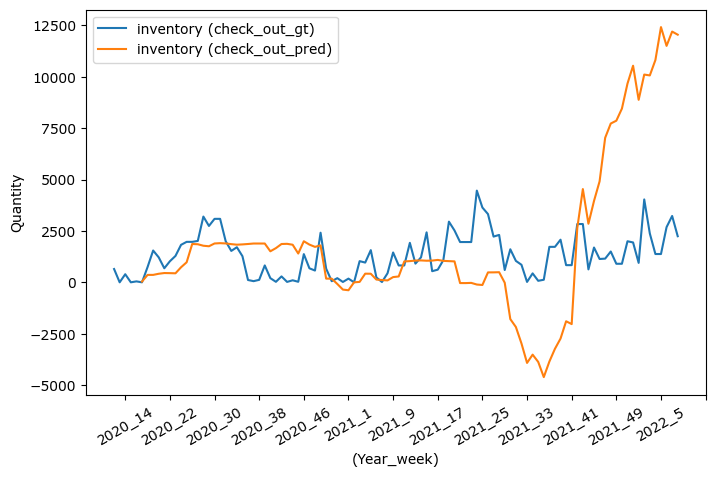

In [50]:
# 可視化結果-比較庫存量
index_num = get_date['Year'].astype('str') + '_' + get_date['week'].astype('str')  # index_num = Year_week (合併年/週)
index_num

plt.figure(figsize = (8,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))  # 設定x軸刻度間距 
plt.plot( index_num , inventory_gt, label='inventory (check_out_gt)')
plt.plot( index_num[seq_len:] , inventory_pred, label='inventory (check_out_pred)')
#plt.plot( (index_num[seq_len : train_pred.shape[0]+seq_len]) , train_pred, label='train_pred')  # train_pred
#plt.plot( (index_num[train_pred.shape[0]+seq_len : ]) , test_pred, label='test_pred')  # test_pred

plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()
plt.show()